# <center>Sales Time Series Prediction</center>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

### Initialize Dataframe

In [2]:
df = pd.read_csv('sales.csv', parse_dates=True, index_col='DATE')
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [3]:
df.rename(columns={'MRTSSM448USN': 'SALES'}, inplace=True)
df.head()

,SALES
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


### Data Analysis

In [4]:
df.isnull().sum()
df.describe()

,SALES
count,385.000000
mean,17257.703896
std,6078.597818
min,2752.000000
25%,12751.000000
50%,16796.000000
75%,20637.000000
max,41187.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385 entries, 1992-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SALES   385 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


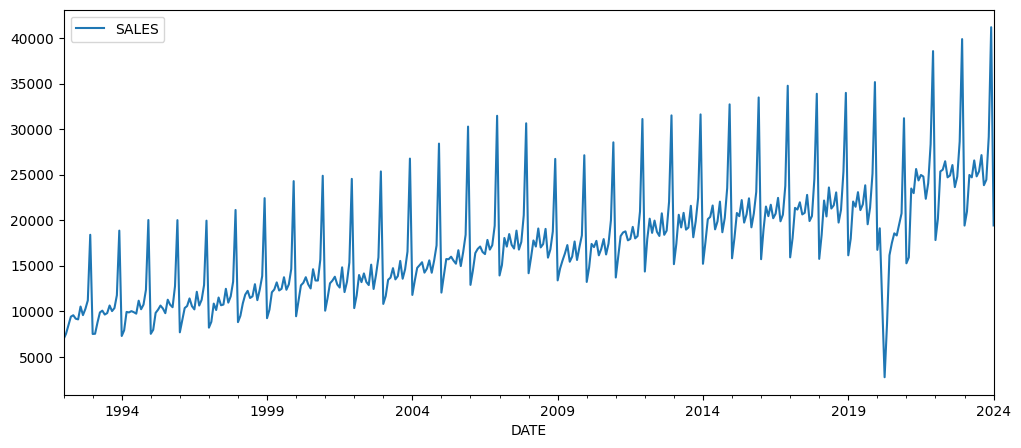

In [6]:
df.plot(figsize=(12, 5))
plt.show()

### Data Preprocessing

In [7]:
test_size = 18
test_ind = len(df) - test_size

In [8]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [9]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [10]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
len(test)

18

In [12]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length, batch_size=1)

### Training the model - LSTM

In [13]:
n_features = 1

In [1]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

NameError: name 'Sequential' is not defined

In [2]:
model.summary()

NameError: name 'model' is not defined

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [17]:
validation_gen = TimeseriesGenerator(scaled_test, scaled_test,
                                    length=length, batch_size=1)

In [18]:
model.fit(generator, epochs=20, validation_data=validation_gen,
         callbacks=[early_stop])

Epoch 1/20
355/355 [==============================] - 5s 8ms/step - loss: 0.0181 - val_loss: 0.0417
Epoch 2/20
355/355 [==============================] - 3s 8ms/step - loss: 0.0127 - val_loss: 0.0282
Epoch 3/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 0.0071
Epoch 4/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 5/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0061 - val_loss: 0.0627
Epoch 6/20
355/355 [==============================] - 2s 7ms/step - loss: 0.0064 - val_loss: 0.0036


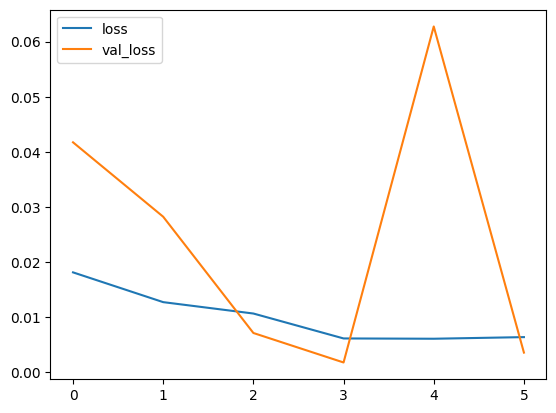

In [19]:
history = pd.DataFrame(model.history.history)
history.plot()
plt.show()

In [20]:
test_pred = []

eval_batch = scaled_train[-length:]
curr_batch = eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    curr_pred = model.predict(curr_batch, verbose=False)[0]
    test_pred.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis=1)

In [21]:
true_pred = scaler.inverse_transform(test_pred)

In [22]:
test['Predictions'] = true_pred

C:\Users\samra\AppData\Local\Temp\ipykernel_7236\3456487850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


In [23]:
test.head()

,SALES,Predictions
DATE,,
2022-08-01,26049.0,23069.343730
2022-09-01,23629.0,21380.004768
2022-10-01,24787.0,22286.091988
2022-11-01,28645.0,25540.512816
2022-12-01,39883.0,35784.796607


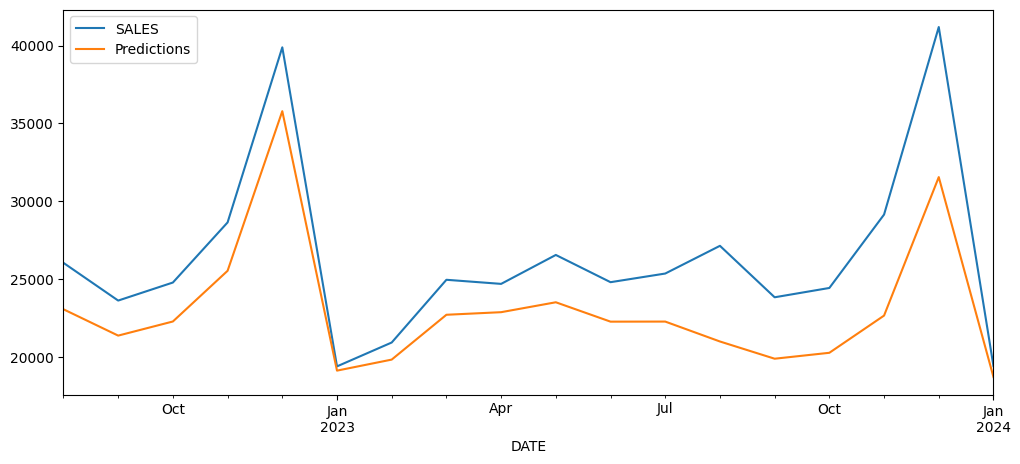

In [24]:
test.plot(figsize=(12, 5))
plt.show()

### Forecasting

In [25]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [26]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [46]:
model.fit(generator, epochs=3)

Epoch 1/3
373/373 [==============================] - 3s 7ms/step - loss: 0.0027
Epoch 2/3
373/373 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 3/3
373/373 [==============================] - 2s 7ms/step - loss: 0.0026


In [47]:
forecast = []
periods = 12

eval_batch = scaled_full_data[-length:]
curr_batch = eval_batch.reshape((1, length, n_features))

for i in range(periods):
    curr_pred = model.predict(curr_batch, verbose=False)[0]
    forecast.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis=1)

In [48]:
forecast = full_scaler.inverse_transform(forecast)

In [49]:
df.tail()

,SALES
DATE,
2023-09-01,23840.0
2023-10-01,24438.0
2023-11-01,29150.0
2023-12-01,41187.0
2024-01-01,19420.0


In [50]:
forecast_ind = pd.date_range(start='2024-02-01', periods=periods,
                            freq='MS')

In [51]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_ind, columns=['Forecast'])

<Axes: xlabel='DATE'>

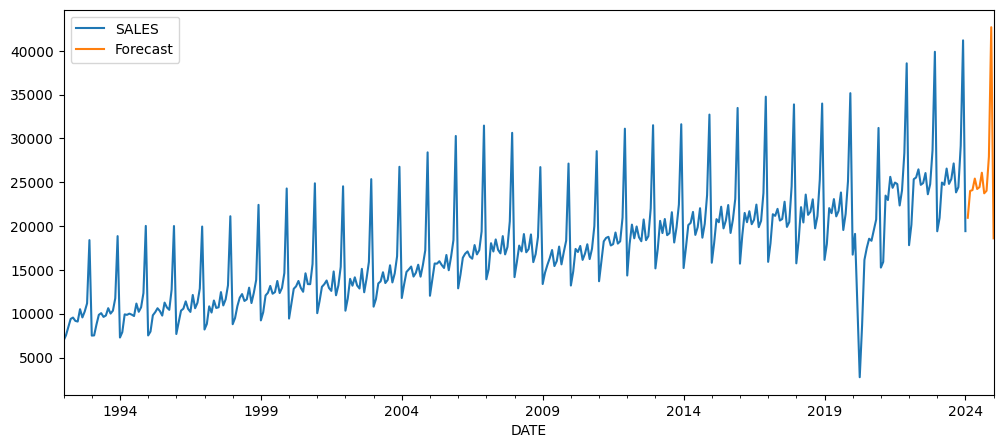

In [52]:
ax = df.plot(figsize=(12, 5))
forecast_df.plot(ax=ax)

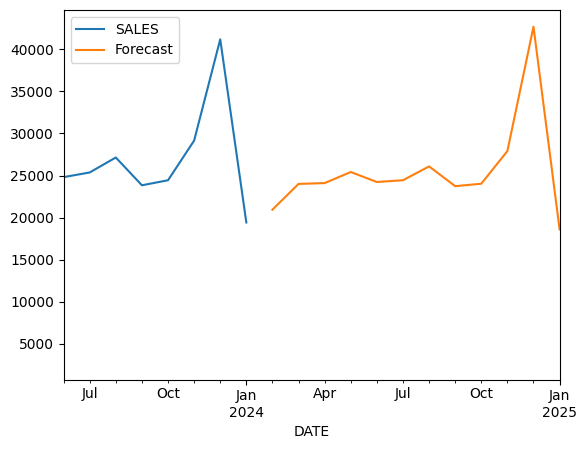

In [57]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2023-06-01', '2025-01-01')
plt.show()